In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("GalaxyClassification") \
    .getOrCreate()

df = spark.read.csv(
    "clean.csv",
    header=True,
    inferSchema=True
)

df.printSchema()
df.show(5)


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/16 14:29:25 WARN Utils: Your hostname, Juliusz-14-inch.local, resolves to a loopback address: 127.0.0.1; using 172.20.10.2 instead (on interface en0)
26/01/16 14:29:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/16 14:29:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- u: double (nullable = true)
 |-- g: double (nullable = true)
 |-- r: double (nullable = true)
 |-- i: double (nullable = true)
 |-- z: double (nullable = true)
 |-- class: integer (nullable = true)
 |-- redshift: double (nullable = true)
 |-- plate: integer (nullable = true)
 |-- MJD: integer (nullable = true)

+--------+--------+--------+--------+--------+-----+---------+-----+-----+
|       u|       g|       r|       i|       z|class| redshift|plate|  MJD|
+--------+--------+--------+--------+--------+-----+---------+-----+-----+
|23.87882| 22.2753|20.39501|19.16573|18.79371|    0|0.6347936| 5812|56354|
|24.77759|22.83188|22.58444|21.16812|21.61427|    0| 0.779136|10445|58158|
|22.13682|23.77656|21.61162|20.50454| 19.2501|    0|0.9323456| 9149|58039|
|19.43718|17.58028|16.49747|15.97711|15.54461|    0|0.1161227| 6121|56187|
|21.46973|21.17624|20.92829|20.60826|20.42573|    2|0.5864546|11069|58456|
+--------+--------+--------+--------+--------+-----+---------+-----+-----+
on

26/01/16 15:25:22 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 471554 ms exceeds timeout 120000 ms
26/01/16 15:25:22 WARN SparkContext: Killing executors is not supported by current scheduler.
26/01/16 15:25:30 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:81)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:669)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1296)
	at o

In [2]:
from pyspark.sql.functions import col

label_col = "class"
feature_cols = [c for c in df.columns if c != label_col]

In [3]:
from pyspark.ml.feature import StringIndexer

label_indexer = StringIndexer(
    inputCol="class",
    outputCol="label"
)

df = label_indexer.fit(df).transform(df)


In [4]:
df.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|59445|
|  1.0|21594|
|  2.0|18961|
+-----+-----+



In [5]:
from pyspark.sql.functions import rand

class_counts = df.groupBy("label").count().collect()
max_count = max(row["count"] for row in class_counts)

balanced_dfs = []

for row in class_counts:
    label = row["label"]
    count = row["count"]
    ratio = max_count / count

    sampled = (
        df.filter(col("label") == label)
          .withColumn("rand", rand())
          .sample(withReplacement=True, fraction=ratio)
          .drop("rand")
    )
    balanced_dfs.append(sampled)

df_balanced = balanced_dfs[0]
for temp_df in balanced_dfs[1:]:
    df_balanced = df_balanced.union(temp_df)

df_balanced.groupBy("label").count().show()


+-----+-----+
|label|count|
+-----+-----+
|  0.0|59034|
|  1.0|59930|
|  2.0|59547|
+-----+-----+



In [6]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

df_balanced = assembler.transform(df_balanced)


In [7]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withMean=True,
    withStd=True
)

scaler_model = scaler.fit(df_balanced)
df_balanced = scaler_model.transform(df_balanced)


In [8]:
train_df, test_df = df_balanced.randomSplit(
    [0.67, 0.33],
    seed=42
)


In [9]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(
    featuresCol="scaledFeatures",
    labelCol="label",
    seed=42
)

rf_model = rf.fit(train_df)
predictions = rf_model.transform(test_df)


26/01/14 23:02:16 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [15]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print(f"Accuracy : {accuracy:.3f}")


Accuracy : 0.955


/opt/anaconda3/lib/python3.13/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


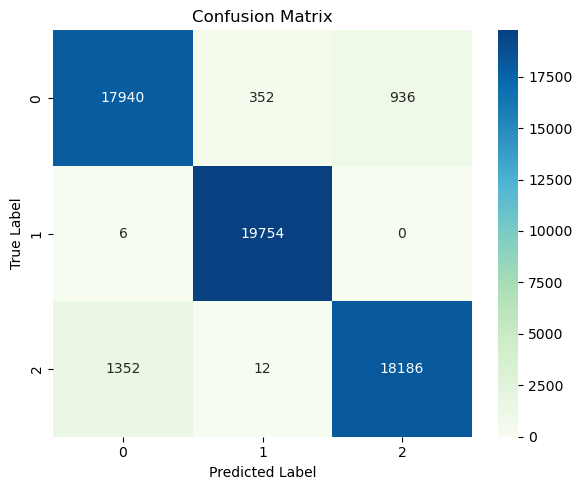

In [16]:
from pyspark.mllib.evaluation import MulticlassMetrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Spark confusion matrix
pred_rdd = predictions.select("prediction", "label").rdd.map(tuple)
metrics = MulticlassMetrics(pred_rdd)
cm = metrics.confusionMatrix().toArray()

# Recover class names safely from original data
class_names = (
    df.select("class")
      .distinct()
      .orderBy("class")
      .rdd.flatMap(lambda x: x)
      .collect()
)

# Convert to pandas DataFrame
cm_df = pd.DataFrame(
    cm,
    index=class_names,
    columns=class_names
)

# Plot with seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_df,
    annot=True,
    fmt=".0f",
    cmap="GnBu"
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [17]:
# Get unique labels from predictions
labels = predictions.select("label").distinct().rdd.flatMap(lambda x: x).collect()

labels = sorted(labels)

for lbl in labels:
    print(f"Class {int(lbl)}")
    print(f" Precision: {metrics.precision(lbl):.3f}")
    print(f" Recall   : {metrics.recall(lbl):.3f}")
    print(f" F1-score : {metrics.fMeasure(lbl):.3f}")
    print()

Class 0
 Precision: 0.930
 Recall   : 0.933
 F1-score : 0.931

Class 1
 Precision: 0.982
 Recall   : 1.000
 F1-score : 0.991

Class 2
 Precision: 0.951
 Recall   : 0.930
 F1-score : 0.941



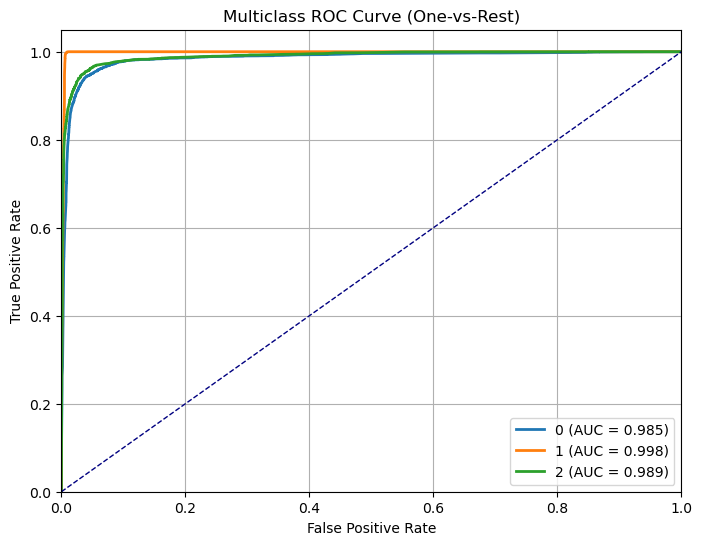

26/01/16 05:19:19 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 920980 ms exceeds timeout 120000 ms
26/01/16 05:19:20 WARN SparkContext: Killing executors is not supported by current scheduler.
26/01/16 05:19:25 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType

# Get class labels (numeric) and names
labels = sorted(predictions.select("label").distinct().rdd.flatMap(lambda x: x).collect())
class_names = sorted(df.select("class").distinct().rdd.flatMap(lambda x: x).collect())

# Convert Spark DataFrame to Pandas for plotting
# Extract: label + probability vector
prob_udf = udf(lambda v: [float(x) for x in v], "array<double>")
pred_pdf = predictions.withColumn("prob_list", prob_udf(col("probability"))) \
                      .select("label", "prob_list") \
                      .toPandas()

# Prepare plot
plt.figure(figsize=(8,6))

for i, cls in enumerate(labels):
    # True binary labels for this class
    y_true = (pred_pdf['label'] == cls).astype(int)
    
    # Predicted probability for this class
    y_score = pred_pdf['prob_list'].apply(lambda x: x[i])
    
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f"{class_names[i]} (AUC = {roc_auc:.3f})")

# Plot diagonal
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
